# Problem Statement
Splice Junction Classification from Sequences Instructions:

You will work on classifying DNA sequences (it is a 3-class classification problem).

The following code will import the Splice-junction Gene Sequences Data Set from the UCI repository as a Pandas DataFrame.

import pandas as pd

import the UCI Molecular Biology (Splice-junction Gene Sequences) Data Set url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data' names = ['Class', 'id', 'Sequence'] data = pd.read_csv(url, names = names) First, you need to preprocess the data. It contains string values, but you need to convert each sample to numerical values to be able to feed it into ML algorithms. Although normal sequence characters are A T G or C, there are some values as D N S and R which were described in dataset source. Yoou need to handle them with care. Finally, you will apply machine learning models to make predictions and compare them with proper metrics.

# Additional Variable Information
One of {n ei ie}, indicating the class. IE borders are referred to a acceptors while EI borders are referred to as donors.
The instance name. 3-62. The remaining 60 fields are the sequence, starting at position -30 and ending at position +30. Each of these fields is almost always filled by one of {a, g, t, c}. Other characters indicate ambiguity among the standard characters according to the following table:
character: meaning

D: A or G or T

N: A or G or C or T

S: C or G

R: A or G

# Importing all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import itertools
import tensorflow.keras.backend as K
sns.set(style='ticks', palette='Set2')

In [2]:
import sys 
!{sys.executable} -m pip install missingno

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import missingno as msno

In [5]:
# import the UCI Molecular Biology (Splice-junction Gene Sequences) Data Set
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data'
names = ['Class', 'id', 'Sequence']
data = pd.read_csv(url, names = names)

# Data Preprocessing

In [6]:
data.head()

,Class,id,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [7]:
data.tail()

,Class,id,Sequence
3185,N,ORAHBPSBD-NEG-2881,TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTT...
3186,N,ORAINVOL-NEG-2161,GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAA...
3187,N,ORARGIT-NEG-241,TCTCGGGGGCGGCCGGCGCGGCGGGGAGCG...
3188,N,TARHBB-NEG-541,ATTCTACTTAGTAAACATAATTTCTTGTG...
3189,N,TARHBD-NEG-1981,AGGCTGCCTATCAGAAGGTGGTGGCTGGTG...


In [8]:
# Check data types and missing values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Class     3190 non-null   object
 1   id        3190 non-null   object
 2   Sequence  3190 non-null   object
dtypes: object(3)
memory usage: 74.9+ KB
None


In [9]:
# Summary statistics of features
data.describe()

,Class,id,Sequence
count,3190,3190,3190
unique,3,3178,3092
top,N,HUMALBGC-ACCEPTOR-18496,CTCCCCACCCACCTGTCCACCCGCCCGCAGATCGCTTC...
freq,1655,2,3


# Exploratory Data Analysis

<Axes: >

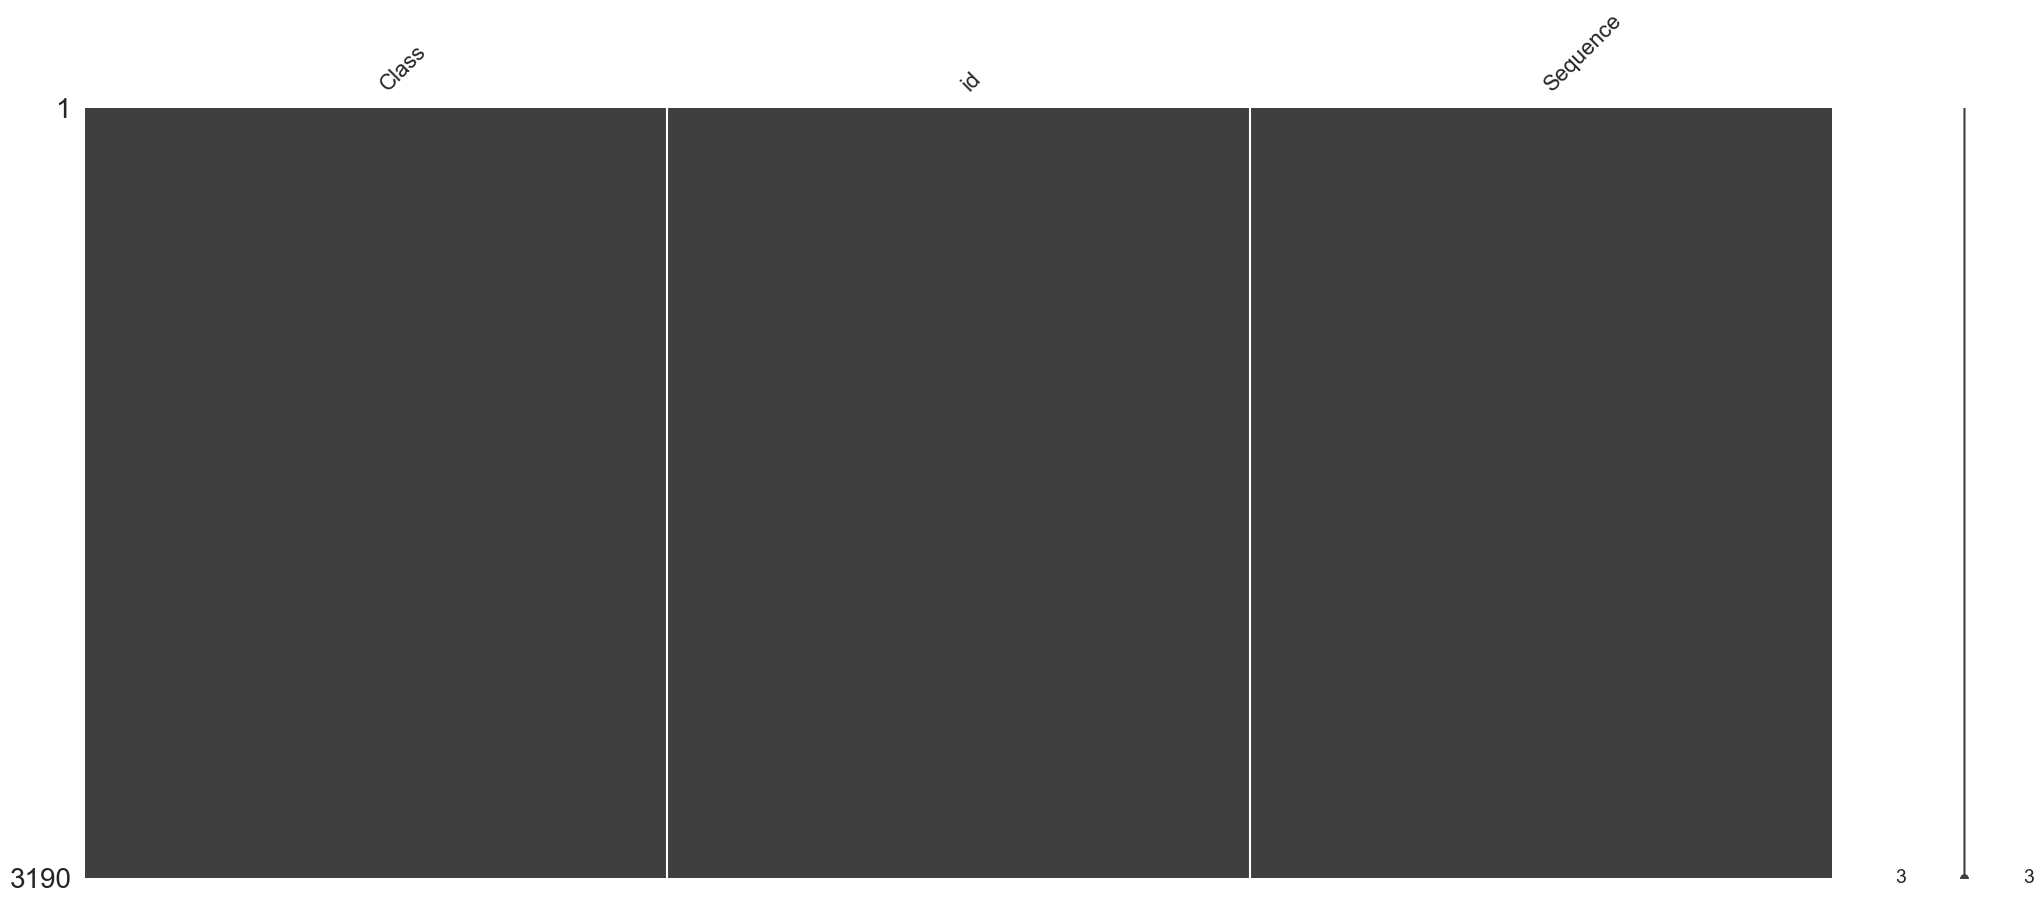

In [10]:
msno.matrix(data)

From the visualization, it seems like all the rows and columns are filled in, indicating that no missing values exist in this dataset.

In [11]:
#get_kmer_counts generates counts of specific subsequences (k-mers) in a list of DNA sequences.
from sklearn.feature_extraction.text import CountVectorizer
def get_kmer_counts(sequence_list, size, num_largest):
    cv = CountVectorizer(analyzer='char', ngram_range=(size, size))
    cv_fit = cv.fit_transform(sequence_list)
    # Use get_feature_names_out instead of get_feature_names
    word_list = cv.get_feature_names_out()
    count_list = cv_fit.toarray().sum(axis=0)
    kmer_df = pd.DataFrame(data={'K-mer': [seq.upper() for seq in word_list], 'Count': count_list})
    return kmer_df.nlargest(num_largest, 'Count')

In [12]:
# To calculate the counts of single character in different subsets of sequences 
base_counts_EI = get_kmer_counts(data[data['Class'] == 'EI']['Sequence'], 1, 10)
base_counts_IE = get_kmer_counts(data[data['Class'] == 'IE']['Sequence'], 1, 10)
base_counts_N = get_kmer_counts(data[data['Class'] == 'N']['Sequence'], 1, 10)

Text(0, 0.5, 'Frequency')

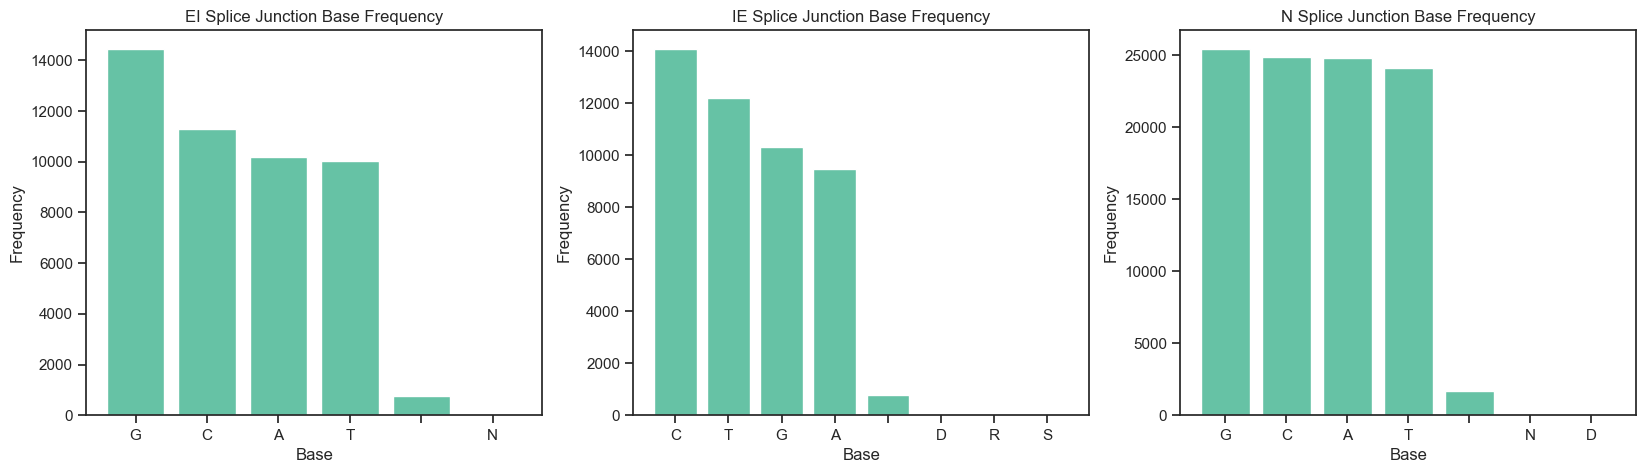

In [13]:
# Displays the frequency of single-cahracter k-meres in different classes of slice junctions.
fig = plt.figure(figsize=(20,5))

ax1 = plt.subplot(1, 3, 1)
plt.bar(base_counts_EI['K-mer'], base_counts_EI['Count'])
plt.xlabel('Base')
ax1.set_title('EI Splice Junction Base Frequency')
plt.ylabel('Frequency')

ax2 = plt.subplot(1, 3, 2)
plt.bar(base_counts_IE['K-mer'], base_counts_IE['Count'])
plt.xlabel('Base')
ax2.set_title('IE Splice Junction Base Frequency')
plt.ylabel('Frequency')


ax3 = plt.subplot(1, 3, 3)
plt.bar(base_counts_N['K-mer'], base_counts_N['Count'])
plt.xlabel('Base')
ax3.set_title('N Splice Junction Base Frequency')
plt.ylabel('Frequency')

In [14]:
# it calculates the count of 6-mers insted of single character.
kmer_counts_EI = get_kmer_counts(data[data['Class'] == 'EI']['Sequence'], 6, 10)
kmer_counts_IE = get_kmer_counts(data[data['Class'] == 'IE']['Sequence'], 6, 10)
kmer_counts_N = get_kmer_counts(data[data['Class'] == 'N']['Sequence'], 6, 10)

Text(0, 0.5, 'Frequency')

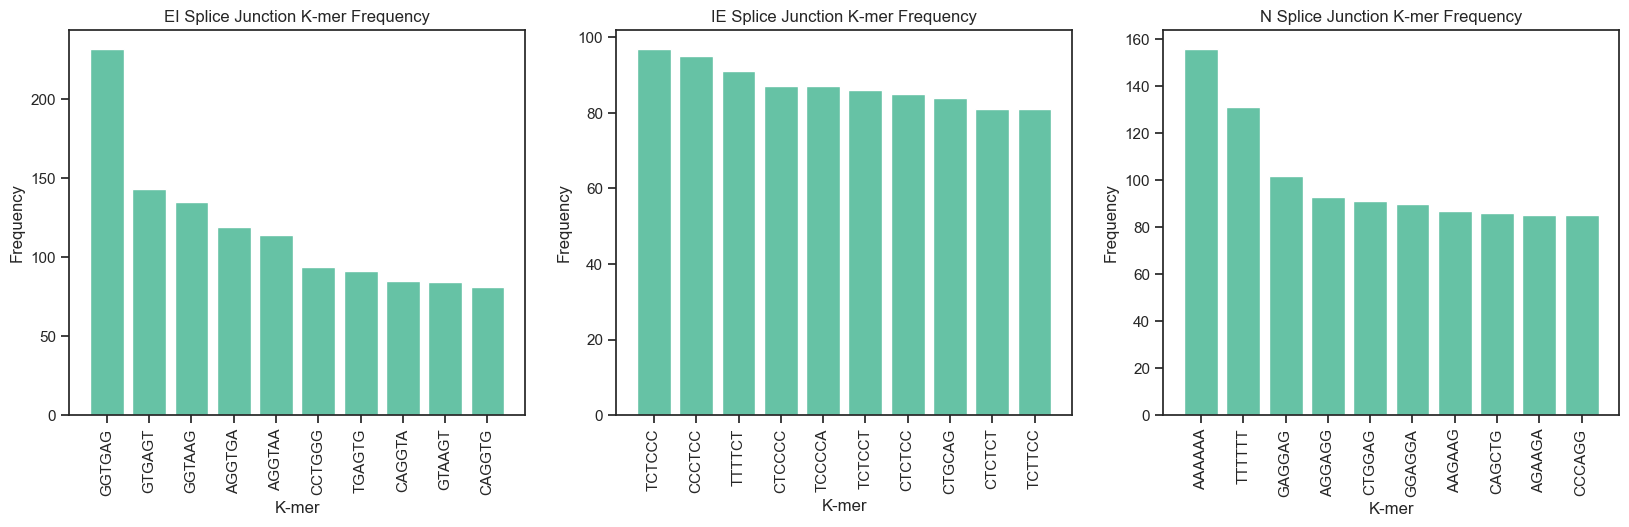

In [15]:
# it displays the frequency of 6 K-mers in different classes of junction.
fig = plt.figure(figsize=(20,5))

ax1 = plt.subplot(1, 3, 1)
plt.bar(kmer_counts_EI['K-mer'], kmer_counts_EI['Count'])
plt.xlabel('K-mer')
plt.xticks(rotation='vertical')
ax1.set_title('EI Splice Junction K-mer Frequency')
plt.ylabel('Frequency')

ax2 = plt.subplot(1, 3, 2)
plt.bar(kmer_counts_IE['K-mer'], kmer_counts_IE['Count'])
plt.xlabel('K-mer')
plt.xticks(rotation='vertical')
ax2.set_title('IE Splice Junction K-mer Frequency')
plt.ylabel('Frequency')


ax3 = plt.subplot(1, 3, 3)
plt.bar(kmer_counts_N['K-mer'], kmer_counts_N['Count'])
plt.xlabel('K-mer')
plt.xticks(rotation='vertical')
ax3.set_title('N Splice Junction K-mer Frequency')
plt.ylabel('Frequency')

<Axes: xlabel='Class', ylabel='count'>

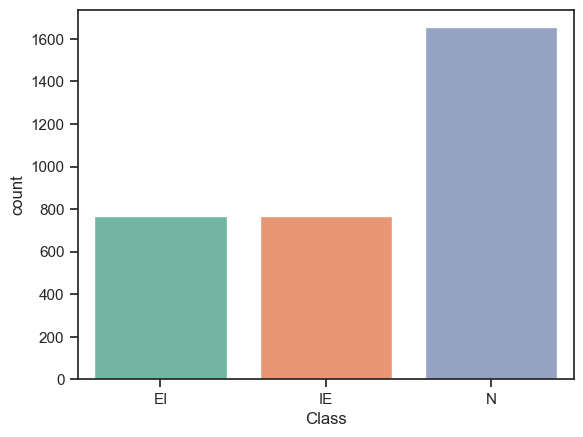

In [16]:
#check the class distribution
sns.countplot(x='Class', data=data)

# SEQUENCE ENCODING

In [17]:
#Here now created a Function to encode DNA sequence data into a one-hot encoded format
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1],
               'N': [0.25, 0.25, 0.25, 0.25], 'S': [0, 0.5, 0.5, 0], 'R': [0.5, 0, 0.5, 0], 'D': [0.33, 0, 0.33, 0.33]}
    return [mapping[char] for char in seq if char in mapping]

#Now Applying the encoding to each sequence
data['Encoded'] = data['Sequence'].apply(one_hot_encode)

In [18]:
def flatten_encoded_sequences(encoded_sequences):
    return [item for sublist in encoded_sequences for item in sublist]

#After encoding, Apply flattening to the encoded sequences
data['Flattened'] = data['Encoded'].apply(flatten_encoded_sequences)

In [19]:
# After flattening,Now Drop the 'Sequence' and 'Encoded' columns
data.drop(['Sequence', 'Encoded'], axis=1, inplace=True)

# After dropping,We Renamed the 'Flattened' column to 'Encoded_sequence'
data.rename(columns={'Flattened': 'Encoded_sequence'}, inplace=True)
data.head()

,Class,id,Encoded_sequence
0,EI,ATRINS-DONOR-521,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
1,EI,ATRINS-DONOR-905,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."
2,EI,BABAPOE-DONOR-30,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
3,EI,BABAPOE-DONOR-867,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ..."
4,EI,BABAPOE-DONOR-2817,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."


In [39]:
X = list(data['Encoded_sequence'])  # Here,Converting column of lists into a list of lists
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shape of the datasets
print("Training set shape:", len(X_train), len(y_train))
print("Testing set shape:", len(X_test), len(y_test))

Training set shape: 2552 2552
Testing set shape: 638 638


# Model Evaluation

# Model 1-Logistic Regression

In [21]:
#First we evaluated the model to find the accuarcy 
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Accuracy of Baseline Logistic Regression:",accuracy_score(y_test,y_pred))
print("Baseline Logistic Regression Performance:")
print(classification_report(y_test, y_pred))

Accuracy of Baseline Logistic Regression: 0.9341692789968652
Baseline Logistic Regression Performance:
              precision    recall  f1-score   support

          EI       0.90      0.93      0.91       179
          IE       0.90      0.93      0.91       140
           N       0.97      0.94      0.96       319

    accuracy                           0.93       638
   macro avg       0.92      0.93      0.93       638
weighted avg       0.94      0.93      0.93       638



In [22]:
# After intial evaluation we did Logistic Regression Model with Cross-Validation to find cross-validated scores
log_reg = LogisticRegression(max_iter=1000)
scores = cross_val_score(log_reg, X_train, y_train, cv=5)
print("Cross-Validated Scores for Logistic Regression:", scores)
print("Average Score:", scores.mean())

Cross-Validated Scores for Logistic Regression: [0.95303327 0.94324853 0.94901961 0.92352941 0.92745098]
Average Score: 0.939256360078278


In [23]:
# Model optimisation by Hyperparameter Tuning with GridSearchCV to improve the accuarcy score
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
grid_search_lr= GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search_lr .fit(X_train, y_train)
print("Best Parameters:", grid_search_lr.best_params_)
y_pred_gs = grid_search_lr.predict(X_test)
print("Tuned Logistic Regression Performance:")
print(classification_report(y_test, y_pred_gs))

Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Tuned Logistic Regression Performance:
              precision    recall  f1-score   support

          EI       0.92      0.95      0.94       179
          IE       0.90      0.95      0.93       140
           N       0.98      0.94      0.96       319

    accuracy                           0.95       638
   macro avg       0.94      0.95      0.94       638
weighted avg       0.95      0.95      0.95       638



# Model 2-Decision tree

In [24]:
#First we evaluated the model to find the accuarcy
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy of Baseline Decision tree:",accuracy_score(y_test,y_pred))
print("Baseline Decision Tree Performance:")
print(classification_report(y_test, y_pred))

Accuracy of Baseline Decision tree: 0.932601880877743
Baseline Decision Tree Performance:
              precision    recall  f1-score   support

          EI       0.94      0.96      0.95       179
          IE       0.88      0.90      0.89       140
           N       0.96      0.93      0.94       319

    accuracy                           0.93       638
   macro avg       0.92      0.93      0.93       638
weighted avg       0.93      0.93      0.93       638



In [25]:
#After intial evaluation we did  Decision Tree Model with Cross-Validation to find cross-validated scores 
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validated Accuracy Scores for Decision Tree:", scores)
print("Average Cross-Validated Accuracy:", scores.mean())

Cross-Validated Accuracy Scores for Decision Tree: [0.92563601 0.91780822 0.93137255 0.89019608 0.91960784]
Average Cross-Validated Accuracy: 0.9169241395188212


In [26]:
# Model optimisation by Hyperparameter Tuning with GridSearchCV to improve the accuarcy score
param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_leaf': [1, 2, 4]}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search_dt.fit(X_train, y_train)
print("Best Parameters:", grid_search_dt.best_params_)
y_pred_gs = grid_search_dt.predict(X_test)
print("Tuned Decision Tree Performance:")
print(classification_report(y_test, y_pred_gs))

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4}
Tuned Decision Tree Performance:
              precision    recall  f1-score   support

          EI       0.95      0.94      0.94       179
          IE       0.83      0.89      0.86       140
           N       0.96      0.94      0.95       319

    accuracy                           0.93       638
   macro avg       0.92      0.92      0.92       638
weighted avg       0.93      0.93      0.93       638



# Model 3-Support Vector Machine (SVM)

In [27]:
#First we evaluated the model to find the accuarcy
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Accuracy of Baseline SVM:",accuracy_score(y_test,y_pred))
print("Baseline SVM Performance:")
print(classification_report(y_test, y_pred))

Accuracy of Baseline SVM: 0.9655172413793104
Baseline SVM Performance:
              precision    recall  f1-score   support

          EI       0.96      0.97      0.96       179
          IE       0.92      0.96      0.94       140
           N       0.99      0.97      0.98       319

    accuracy                           0.97       638
   macro avg       0.96      0.96      0.96       638
weighted avg       0.97      0.97      0.97       638



In [28]:
## After intial evaluation we did SVM Model with Cross-Validation to find cross-validated scores
svm = SVC()
scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validated Accuracy Scores for SVM:", scores)
print("Average Cross-Validated Accuracy:", scores.mean())

Cross-Validated Accuracy Scores for SVM: [0.97064579 0.97064579 0.96666667 0.95294118 0.95490196]
Average Cross-Validated Accuracy: 0.9631602778097541


In [29]:
# Model optimisation by Hyperparameter Tuning with GridSearchCV to improve the accuarcy score
param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
fy_pred_gs = grid_search.predict(X_test)
print("Tuned SVM Performance:")
print(classification_report(y_test, y_pred_gs))

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Tuned SVM Performance:
              precision    recall  f1-score   support

          EI       0.96      0.97      0.96       179
          IE       0.92      0.96      0.94       140
           N       0.99      0.97      0.98       319

    accuracy                           0.97       638
   macro avg       0.96      0.96      0.96       638
weighted avg       0.97      0.97      0.97       638



# Model 4-Random forest

In [30]:
#First we evaluated the model to find the accuarcy
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy of Baseline Random Forest:",accuracy_score(y_test,y_pred))
print("Baseline Random Forest Performance:")
print(classification_report(y_test, y_pred))

Accuracy of Baseline Random Forest: 0.9686520376175548
Baseline Random Forest Performance:
              precision    recall  f1-score   support

          EI       0.99      0.96      0.98       179
          IE       0.91      0.98      0.94       140
           N       0.98      0.97      0.97       319

    accuracy                           0.97       638
   macro avg       0.96      0.97      0.97       638
weighted avg       0.97      0.97      0.97       638



In [31]:
# # After intial evaluation we did Random Forest  Model with Cross-Validation to find cross-validated scores
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross-Validated Scores for Random Forest:", scores)
print("Average Score:", scores.mean())

Cross-Validated Scores for Random Forest: [0.9667319  0.96868885 0.95294118 0.95490196 0.94509804]
Average Score: 0.9576723840221021


In [32]:
# Model optimisation by Hyperparameter Tuning with GridSearchCV to improve the accuarcy score
param_grid = {'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2']}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search_rf.fit(X_train, y_train)
print("Best Parameters:", grid_search_rf.best_params_)
y_pred_gs = grid_search_rf.predict(X_test)
print("Tuned Random Forest Performance:")
print(classification_report(y_test, y_pred_gs))

Best Parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Tuned Random Forest Performance:
              precision    recall  f1-score   support

          EI       0.98      0.94      0.96       179
          IE       0.91      0.95      0.93       140
           N       0.96      0.97      0.97       319

    accuracy                           0.96       638
   macro avg       0.95      0.95      0.95       638
weighted avg       0.96      0.96      0.96       638



# Model 5-KNN

In [33]:
#First we evaluated the model to find the accuarcy
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy of Baseline KNN:",accuracy_score(y_test,y_pred))
print("Baseline KNN Performance:")
print(classification_report(y_test, y_pred))

Accuracy of Baseline KNN: 0.7037617554858934
Baseline KNN Performance:
              precision    recall  f1-score   support

          EI       0.56      0.95      0.71       179
          IE       0.69      0.86      0.76       140
           N       0.99      0.50      0.66       319

    accuracy                           0.70       638
   macro avg       0.75      0.77      0.71       638
weighted avg       0.80      0.70      0.70       638



In [34]:
# After intial evaluation we did KNN Model with Cross-Validation to find cross-validated scores
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X_train, y_train, cv=5)
print("Cross-Validated Scores for KNN:", scores)
print("Average Score:", scores.mean())

Cross-Validated Scores for KNN: [0.70254403 0.69667319 0.76078431 0.68039216 0.69803922]
Average Score: 0.707686581481908


In [35]:
# Model optimisation by Hyperparameter Tuning with GridSearchCV to improve the accuarcy score
param_grid = {'n_neighbors': [3, 5, 7, 10]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
y_pred_gs = grid_search.predict(X_test)
print("Tuned KNN Performance:")
print(classification_report(y_test, y_pred_gs))

Best Parameters: {'n_neighbors': 10}
Tuned KNN Performance:
              precision    recall  f1-score   support

          EI       0.70      0.95      0.81       179
          IE       0.71      0.91      0.80       140
           N       1.00      0.68      0.81       319

    accuracy                           0.81       638
   macro avg       0.80      0.85      0.80       638
weighted avg       0.85      0.81      0.81       638



# Compare all models

In [36]:
classifiers = {'Logistic Regression': log_reg,
               'Decision Tree': dt,
               'Random Forest': rf,
               'SVM': svm,
               'KNN': knn}

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Loop through each classifier
for clf_name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract precision, recall, and F1 score for each class
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Create a DataFrame for the current results and concatenate it with the main DataFrame
    current_results = pd.DataFrame({
        'Classifier': [clf_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })
    
    results_df = pd.concat([results_df, current_results], ignore_index=True)

# Print the results DataFrame
print(results_df)

            Classifier  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.934169   0.935290  0.934169  0.934498
1        Decision Tree  0.927900   0.930132  0.927900  0.928565
2        Random Forest  0.971787   0.972226  0.971787  0.971906
3                  SVM  0.965517   0.966198  0.965517  0.965696
4                  KNN  0.703762   0.804758  0.703762  0.697039


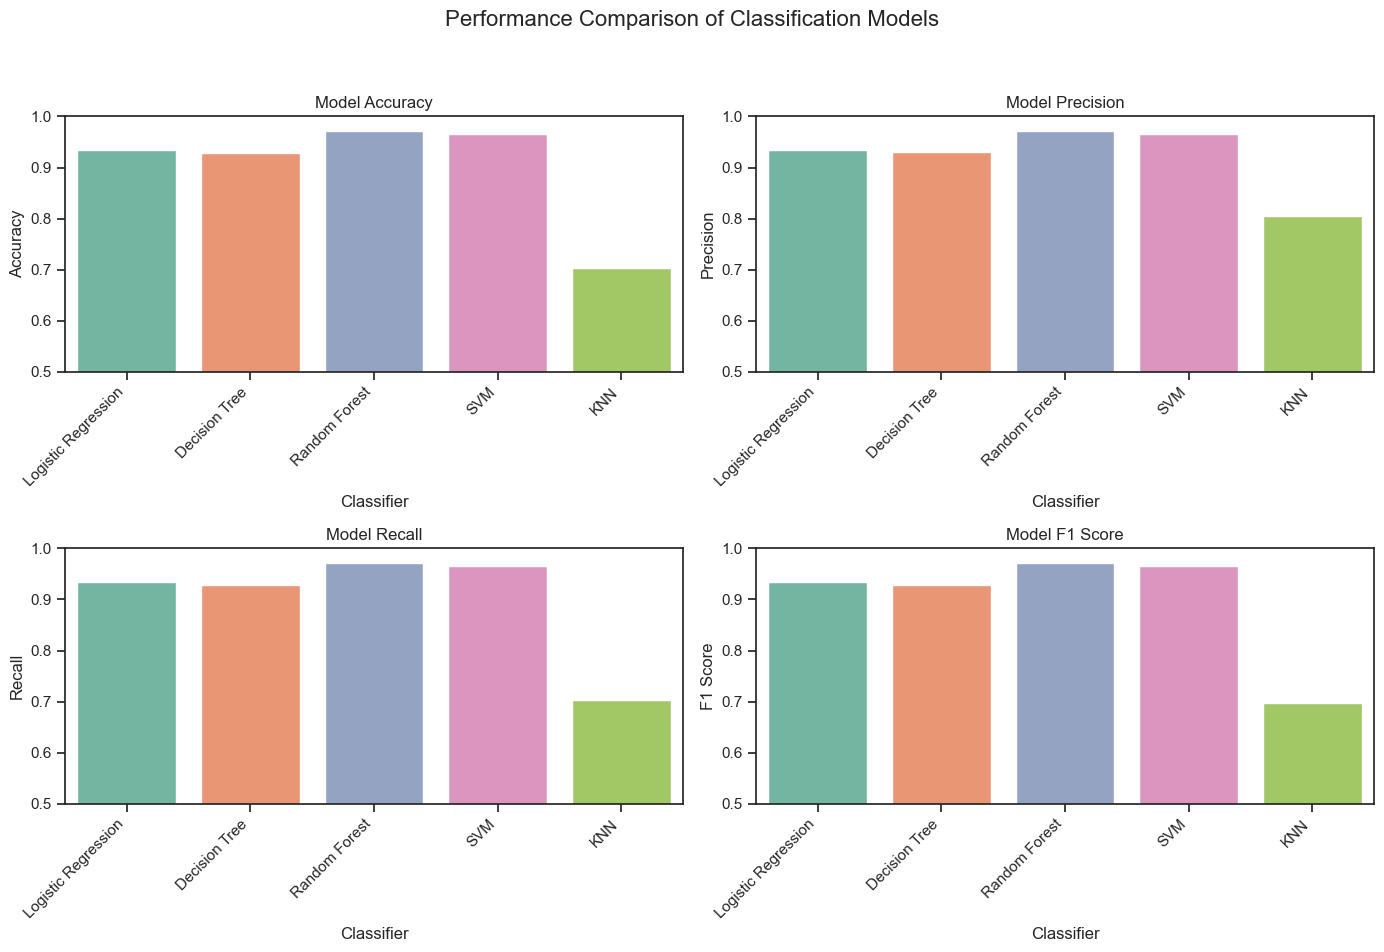

In [37]:
# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Performance Comparison of Classification Models', fontsize=16)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
ax_iter = iter(axes.flatten())  # Create an iterator to go through the subplot axes

for metric in metrics:
    ax = next(ax_iter)  # Get the next axis object from the iterator
    sns.barplot(x='Classifier', y=metric, data=results_df, ax=ax)
    ax.set_title(f'Model {metric}')
    ax.set_ylim(0.5, 1.0)  # Set a dynamic range if needed based on your data
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the title
plt.show()

# Ensembling

In [38]:
# Create an ensemble of the best models
best_lr = grid_search_lr.best_estimator_
best_dt = grid_search_dt.best_estimator_
best_rf = grid_search_rf.best_estimator_

ensemble = VotingClassifier(estimators=[
    ('lr', best_lr), ('dt', best_dt), ('rf', best_rf)
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
print("Ensemble Model Performance:")
print(classification_report(y_test, y_pred_ensemble))

Ensemble Model Performance:
              precision    recall  f1-score   support

          EI       0.99      0.98      0.99       179
          IE       0.90      0.98      0.94       140
           N       0.99      0.95      0.97       319

    accuracy                           0.97       638
   macro avg       0.96      0.97      0.96       638
weighted avg       0.97      0.97      0.97       638



# Conclusion:
Random forest classifier has high performance compared to all models with accuarcy of 0.97 and F1 score as 0.97.
                   
After random forest ,SVM shows strong performanc with accuarcy score of 0.96 and 

KNN shows least performanace wth accuracy of 0.70 